# Demo for Hybrid Payoff Bandits

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from algorithms import HyLinUCB, DisLinUCB, LinUCBLangford, HyLinUCBv2, LinUCB
from environment import HybridBandits

In [2]:
def probe_algo(env: HybridBandits, algo_arr, nrows, ncols):
    theta_dict = {}
    beta_dict = {}
    algo_dict = {}
    for algo in algo_arr:
        if algo.name.startswith('LinUCBLangford'):
            theta_dict['LinUCBLangford'] = algo.theta_hat
            beta_dict['LinUCBLangford'] = algo.beta_hat_arr
            algo_dict['LinUCBLangford'] = algo
        elif algo.name.startswith('DisLinUCB'):
            theta_dict['DisLinUCB'] = algo.theta_hat_arr
            algo_dict['DisLinUCB'] = algo
        elif algo.name.startswith('HyLinUCB'):
            theta_dict['HyLinUCB'] = algo.theta_hat
            beta_dict['HyLinUCB'] = algo.beta_hat_arr
            algo_dict['HyLinUCB'] = algo
        elif algo.name.startswith('LinUCB'):
            theta_dict['LinUCB'] = algo.theta_hat
            algo_dict['LinUCB'] = algo
    if ncols <= 1:
        fig, ax = plt.subplots(nrows, sharex=False, sharey=False, figsize=(30, 30))
        x = 0
        base = np.arange(1, env.L + 1)
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            reward_arr = np.zeros((env.L, 2*(len(algo_arr)+1)))
            reward_bonuses = np.zeros((env.L, len(algo_arr)+1))
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr[j, 0], reward_arr[j, 1] = np.dot(theta, a), np.dot(beta_arr[j], b)
                for k, keyname in enumerate(algo_dict.keys()):
                    if keyname == 'DisLinUCB':
                        reward_arr[j, 2*(k+1)] = np.dot(theta_dict['DisLinUCB'][j][:env.d], a)
                        reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict['DisLinUCB'][j][env.d:], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=np.concatenate((a,b))) - s
                    elif keyname == 'LinUCB':
                        reward_arr[j, 2*(k+1)] = np.dot(theta_dict['LinUCB'][:env.d], a)
                        reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict['LinUCB'][env.d + j*env.k: env.d + (j+1)*env.k], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        ar = np.zeros((env.d + env.k*env.L,))
                        ar[:env.d] = a
                        ar[env.d + j*env.k: env.d + (j+1)*env.k] = b
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=ar) - s
                    else:
                        reward_arr[j, 2*(k+1)], reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict[keyname], a), np.dot(beta_dict[keyname][j], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=(a,b)) - s
            columns = ['True_theta', 'True_beta']
            col_theta, col_beta = ['True_theta'], ['True_beta']
            for k in algo_dict.keys():
                columns += [k + '_theta']
                col_theta += [k + '_theta']
                columns += [k + '_beta']
                col_beta += [k + '_beta']
            df = pd.DataFrame(reward_arr, columns=columns, index=base)
            width = 0.2
            l = 0
            for col in col_theta:
                offset = width * l
                ax[x].bar(x=base + offset, height=df[col], width=width, label=col)
                l += 1
            l = 0
            for c1, c2 in zip(col_beta, col_theta):
                offset = width * l
                ax[x].bar(x=base + offset, height=df[c1], bottom=df[c2], width=width, yerr=reward_bonuses[:, l], label=c1)
                l += 1
            ax[x].legend().set_visible(False)
            ax[x].set_title(f'Context:{i}')
            ax[x].grid()
            x += 1
        handles, labels = ax[-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
        plt.show()
    else:
        fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(30, 30))
        x, y = 0, 0
        base = np.arange(1, env.L + 1)
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            if x == nrows:
                x = 0
                y += 1
            reward_arr = np.zeros((env.L, 2*(len(algo_arr)+1)))
            reward_bonuses = np.zeros((env.L, len(algo_arr)+1))
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr[j, 0], reward_arr[j, 1] = np.dot(theta, a), np.dot(beta_arr[j], b)
                for k, keyname in enumerate(algo_dict.keys()):
                    if keyname == 'DisLinUCB':
                        reward_arr[j, 2*(k+1)] = np.dot(theta_dict['DisLinUCB'][j][:env.d], a)
                        reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict['DisLinUCB'][j][env.d:], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=np.concatenate((a,b))) - s
                    elif keyname == 'LinUCB':
                        reward_arr[j, 2*(k+1)] = np.dot(theta_dict['LinUCB'][:env.d], a)
                        reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict['LinUCB'][env.d + j*env.k: env.d + (j+1)*env.k], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        ar = np.zeros((env.d + env.k*env.L,))
                        ar[:env.d] = a
                        ar[env.d + j*env.k: env.d + (j+1)*env.k] = b
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=ar) - s
                    else:
                        reward_arr[j, 2*(k+1)], reward_arr[j, 2*(k+1) + 1] = np.dot(theta_dict[keyname], a), np.dot(beta_dict[keyname][j], b)
                        s = reward_arr[j, 2*(k+1)] + reward_arr[j, 2*(k+1)+1]
                        reward_bonuses[j, k+1] = algo_dict[keyname].get_reward_estimate(j, a=(a,b)) - s
            columns = ['True_theta', 'True_beta']
            col_theta, col_beta = ['True_theta'], ['True_beta']
            for k in algo_dict.keys():
                columns += [k + '_theta']
                col_theta += [k + '_theta']
                columns += [k + '_beta']
                col_beta += [k + '_beta']
            df = pd.DataFrame(reward_arr, columns=columns, index=base)
            width = 0.2
            l = 0
            for col in col_theta:
                offset = width * l
                ax[x][y].bar(x=base + offset, height=df[col], width=width, label=col)
                l += 1
            l = 0
            for c1, c2 in zip(col_beta, col_theta):
                offset = width * l
                ax[x][y].bar(x=base + offset, height=df[c1], bottom=df[c2], width=width, yerr=reward_bonuses[:, l], label=c1)
                l += 1
            ax[x][y].legend().set_visible(False)
            ax[x][y].set_title(f'Context:{i}')
            ax[x][y].grid()
            x += 1
        handles, labels = ax[-1][-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
        plt.show()

In [3]:
def plot_action_freq(ls, env, nrows, ncols):
        if ncols <= 1:
            fig, ax = plt.subplots(nrows, sharex=False, sharey=False, figsize=(30, 30))
            x = 0
            base = [str(i) for i in np.arange(1, env.L + 1)]
            for i in range(env.num_context):
                act_freq_dict = ls[i]
                data = {}
                base_copy = [b for b in base]
                for k in act_freq_dict.keys():
                    data[k] = []
                    for a in range(env.L):
                        freq = np.sum(np.array(act_freq_dict[k]) == a)
                        if a == env.best_arm[i] and not(base_copy[a].endswith('*')):
                            base_copy[a] += '*'
                        data[k].append(freq)
                df = pd.DataFrame(data, index=base_copy)
                df.plot.bar(rot=0, width=0.8, ax=ax[x])
                ax[x].legend().set_visible(False)
                ax[x].set_title(f'Context:{i}')
                ax[x].grid()
                x += 1
            handles, labels = ax[-1].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
            plt.show()
        else:
            fig, ax = plt.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(30, 30))
            x, y = 0, 0
            base = [str(i) for i in np.arange(1, env.L + 1)]
            for i in range(env.num_context):
                if x == nrows:
                    x = 0
                    y += 1
                act_freq_dict = ls[i]
                data = {}
                base_copy = [b for b in base]
                for k in act_freq_dict.keys():
                    data[k] = []
                    for a in range(env.L):
                        freq = np.sum(np.array(act_freq_dict[k]) == a)
                        if a == env.best_arm[i] and not(base_copy[a].endswith('*')):
                            base_copy[a] += '*'
                        data[k].append(freq)
                df = pd.DataFrame(data, index=base_copy)
                df.plot.bar(rot=0, width=0.8, ax=ax[x][y])
                ax[x][y].legend().set_visible(False)
                ax[x][y].set_title(f'Context:{i}')
                ax[x][y].grid()
                x += 1
            handles, labels = ax[-1][-1].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.9), ncols=2)
            plt.show()

In [4]:
# Function to run 1 trial
def simulate(env, algo_arr, T, display=None):
    d = {}
    for algo in algo_arr:
        if algo.name.startswith('LinUCBLangford'):
            d['LinUCBLangford'] = []
        elif algo.name.startswith('DisLinUCB'):
            d['DisLinUCB'] = []
        elif algo.name.startswith('HyLinUCB'):
            d['HyLinUCB'] = []
        elif algo.name.startswith('LinUCB'):
            d['LinUCB'] = []
    con_act_ls = [deepcopy(d) for _ in range(env.num_context)]
    for t in tqdm(range(T)):
        t = t % T
        a_t = []
        context_id = env.context_seq[env.t]
        for algo in algo_arr:
            a = algo.next_action()
            if algo.name.startswith('LinUCBLangford'):
                con_act_ls[context_id]['LinUCBLangford'].append(a)
            elif algo.name.startswith('DisLinUCB'):
                con_act_ls[context_id]['DisLinUCB'].append(a)
            elif algo.name.startswith('HyLinUCB'):
                con_act_ls[context_id]['HyLinUCB'].append(a)
            elif algo.name.startswith('LinUCB'):
                con_act_ls[context_id]['LinUCB'].append(a)
            a_t.append(a)
        rewards_t, regrets_t, action_set_t = env.step(a_t)
        for i, algo in enumerate(algo_arr):
            algo.update(rewards_t[i], regrets_t[i], action_set_t)
        if display is not None:
            if ((t+1) % display) == 0:
                nr = 5
                #print('Timestep:', (t+1))
                #probe_algo(env, algo_arr, nrows=nr, ncols=env.num_context // nr)
    #plot_action_freq(con_act_ls, env, nrows=nr, ncols=env.num_context // nr)
    return con_act_ls

In [5]:
def create_reward_plot(env:HybridBandits, nrows, ncols):
    if nrows <= 1:
        fig, ax = plt.subplots(ncols, sharex=True, sharey=True)
        x = 0
        base = np.arange(1, env.L + 1)
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            reward_arr = []
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr.append(np.dot(theta, a) + np.dot(beta_arr[j], b))
            ax[x].bar(base, reward_arr)
            ax[x].grid()
            x += 1
        plt.show()
    else:
        fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
        x, y = 0, 0
        base = np.arange(1, env.L + 1)
        theta = env.parameters['theta']
        beta_arr = env.parameters['beta']
        for i in range(env.num_context):
            if x == nrows:
                x = 0
                y += 1
            reward_arr = []
            for j, (a,b) in enumerate(env.arms[i]):
                reward_arr.append(np.dot(theta, a) + np.dot(beta_arr[j], b))
            ax[x][y].bar(base, reward_arr)
            ax[x][y].grid()
            x += 1
            y += 1
        plt.show()
    

In [6]:
def plot_regret(result_dict, T):
    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    x = np.arange(1, T+1)
    for k in result_dict.keys():
        ax[0][0].plot(x, result_dict[k]['mean_reward'], label=k)
        min_reward = np.array(result_dict[k]['mean_reward']) - np.array(result_dict[k]['std_reward'])
        max_reward = np.array(result_dict[k]['mean_reward']) + np.array(result_dict[k]['std_reward'])
        ax[0][0].fill_between(x, min_reward, max_reward, alpha=0.2)

        ax[0][1].plot(x, result_dict[k]['mean_regret'], label=k)
        min_regret = np.array(result_dict[k]['mean_regret']) - np.array(result_dict[k]['std_regret'])
        max_regret = np.array(result_dict[k]['mean_regret']) + np.array(result_dict[k]['std_regret'])
        ax[0][1].fill_between(x, min_regret, max_regret, alpha=0.2)

        ax[1][0].plot(x, result_dict[k]['time_avg_reward'], label=k)
        ax[1][1].plot(x, result_dict[k]['time_avg_regret'], label=k)

    for i in range(2):
        for j in range(2):
            ax[i][j].set_xlabel('Time Steps')
            ax[i][j].grid()
            ax[i][j].legend()
    
    ax[0][0].set_ylabel('Cumulative Reward')
    ax[0][1].set_ylabel('Cumulative Regret')
    ax[1][0].set_ylabel('Time Avg Reward')
    ax[1][1].set_ylabel('Time Avg Regret')
    
    plt.show()

In [7]:
def multi_simulation(num_trials, algo_dict, env:HybridBandits, delta:float, T:int, display:int):
    all_rewards = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]
    all_regrets = [np.zeros((num_trials, T)) for _ in range(len(algo_dict.keys()))]
    for i in range(num_trials):
        algo_arr = []
        for k in algo_dict.keys():
            if k == 'HyLinUCB':
                lmbda = algo_dict[k]['lambda']
                gamma = algo_dict[k]['gamma']
                algo_arr.append(HyLinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, env.sigma, lmbda, gamma))
            elif k == 'DisLinUCB':
                lmbda = algo_dict[k]['lambda']
                algo_arr.append(DisLinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, env.sigma, lmbda))
            elif k == 'LinUCBLangford':
                alpha = algo_dict[k]['alpha']
                algo_arr.append(LinUCBLangford(env.get_first_action_set(), env.M, env.N, env.S1, env.S2, alpha))
            elif k == 'HyLinUCBv2':
                lmbda = algo_dict[k]['lambda']
                gamma = algo_dict[k]['gamma']
                algo_arr.append(HyLinUCBv2(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, lmbda, gamma))
            elif k == 'LinUCB':
                lmbda = algo_dict[k]['lambda']
                algo_arr.append(LinUCB(env.get_first_action_set(), delta, env.M, env.N, env.S1, env.S2, env.sigma, lmbda))
        print('Simulating Trial', i+1)
        ls = simulate(env, algo_arr, T, display=display)
        env.reset()
        for j in range(len(algo_arr)):
            all_rewards[j][i] += np.array(algo_arr[j].rewards)
            all_regrets[j][i] += np.array(algo_arr[j].regrets)
    return all_rewards, all_regrets, ls

In [8]:
# Store results

def create_result_dict(all_rewards, all_regrets, algo_dict):
        result_dict = {}
        for i, algo in enumerate(algo_dict.keys()):
                mean_reward = np.mean(all_rewards[i], axis=0)
                std_reward = np.std(all_rewards[i], axis=0)
                mean_regret = np.mean(all_regrets[i], axis=0)
                std_regret = np.std(all_regrets[i], axis=0)
                rewards = np.cumsum(mean_reward)
                regrets = np.cumsum(mean_regret)
                time_avg_rewards = rewards / np.arange(1, T+1)
                time_avg_regrets = regrets / np.arange(1, T+1)
                results = {'mean_reward': rewards, 'mean_regret': regrets, 'std_reward': std_reward,\
                        'std_regret': std_regret,\
                        'time_avg_reward': time_avg_rewards, 'time_avg_regret': time_avg_regrets}
                result_dict[algo] = results
        return result_dict

In [183]:
# Define Environment Configuration

config = {}
config['seed'] = 984397                 #np.random.randint(1098321) # Uncomment the random seed generator for random instances
print('Seed:', config['seed'])
config['model_type'] = 'Linear'
config['horizon_length'] = 3000       # Number of time steps T
config['num_labels'] = 10               # Number of actions L
config['num_context'] = 10              # Context set size
config['theta_dim'] = 2                 # Dimension of theta d
config['beta_dim'] = 8                  # Dimension of beta k
config['theta_norm'] = 0.2              # Max norm of theta M
config['beta_norm'] = 0.8               # Max norm of beta_i's N
config['x_norm'] = 1.0                  # Max norm of x
config['z_norm'] = 1.0                  # Max norm of z
config['subgaussian'] = 0.01             # Subgaussianity of noise
config['is_easy'] = False                # Flag for whether the instance is easy (large suboptimality gap)
env_name = 'Testbench'                  # Name of the simulation

Seed: 984397


In [184]:
env = HybridBandits(name=env_name, config=config)

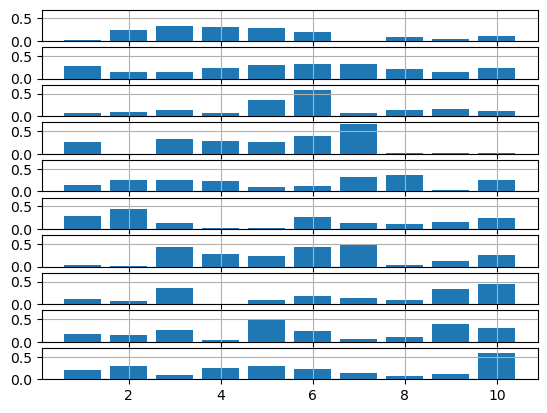

In [185]:
nrows = env.num_context // 10
create_reward_plot(env, nrows, 10)

In [186]:
# Add the algorithms to test and their hyperparameters
algo_dict = {'LinUCB': {'lambda': 0.1},
             'LinUCBLangford': {'alpha': 0.01},
             'DisLinUCB': {'lambda': 0.1}}
delta = 0.001 # High probability guarantee

In [187]:
# Code to run multiple trials

num_trials = 1  # Number of trials
T = env.T
display = T // 5

In [188]:
env.reset()

In [189]:
rewards, regrets, ls = multi_simulation(num_trials, algo_dict, env, delta, T, display)
result_dict = create_result_dict(rewards, regrets, algo_dict)

Simulating Trial 1


100%|██████████| 3000/3000 [00:07<00:00, 380.53it/s]


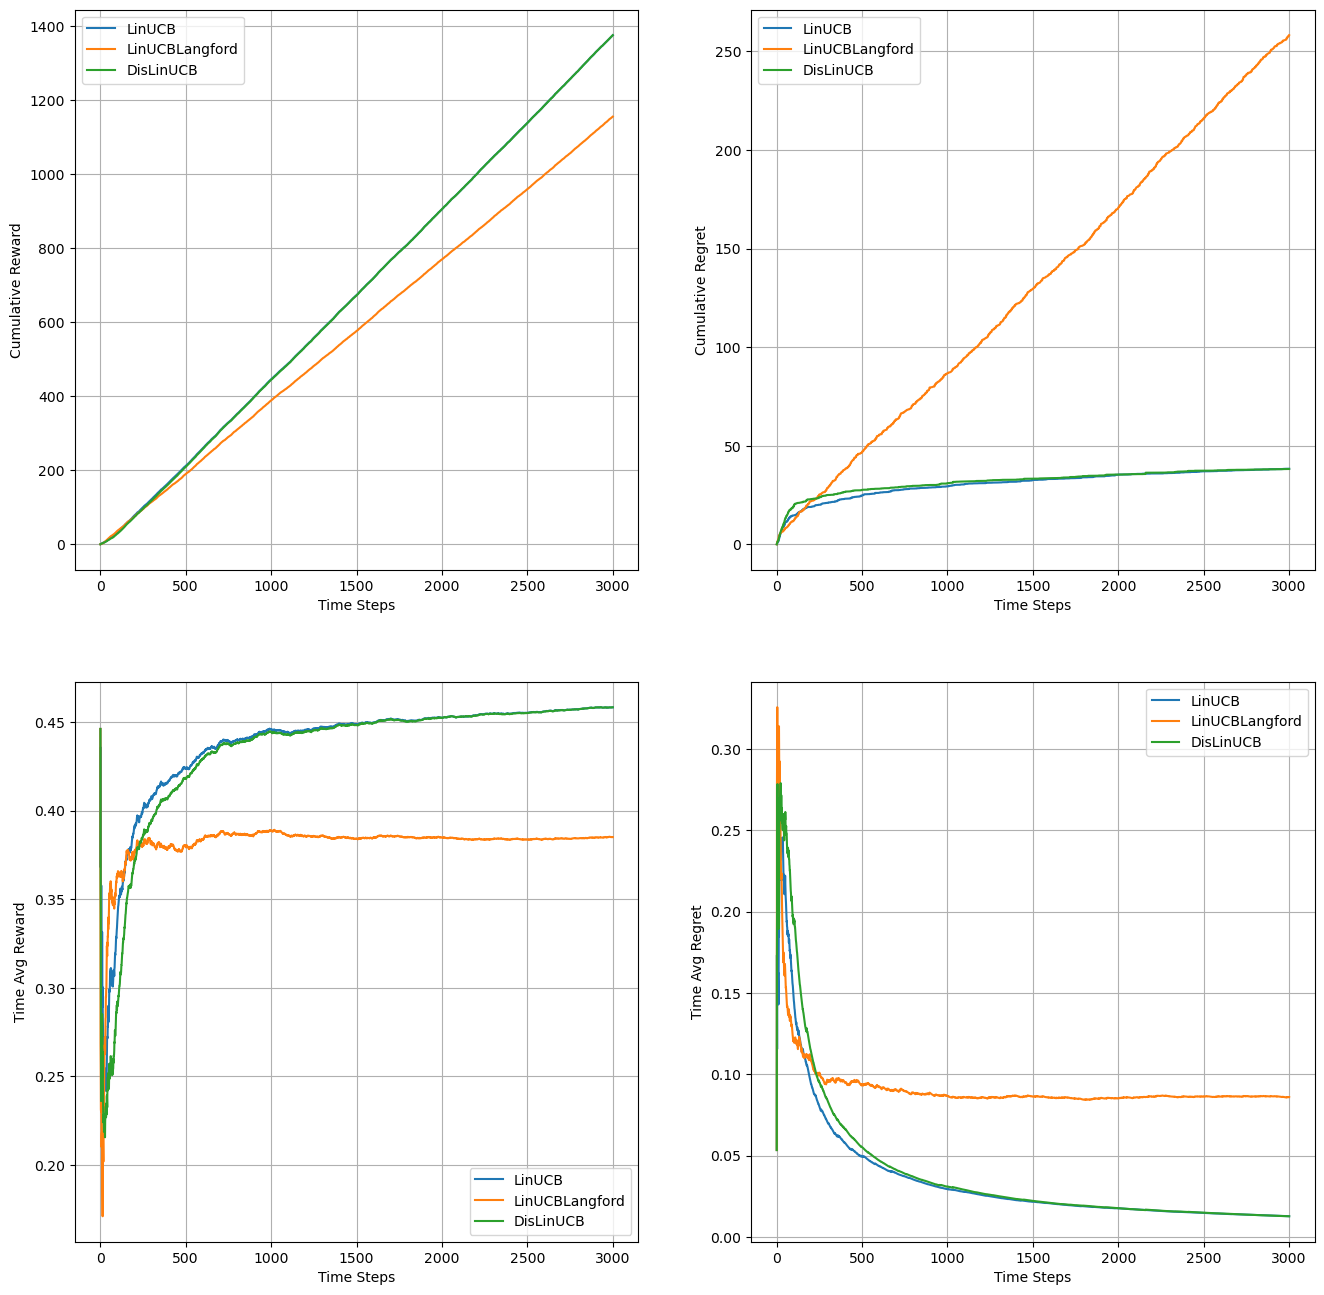

In [190]:
plot_regret(result_dict, env.T)

In [171]:
# Define Environment Configuration

config = {}
config['seed'] = 984397                 #np.random.randint(1098321) # Uncomment the random seed generator for random instances
print('Seed:', config['seed'])
config['model_type'] = 'Linear'
config['horizon_length'] = 3000       # Number of time steps T
config['num_context'] = 10              # Context set size
config['theta_dim'] = 5                 # Dimension of theta d
config['beta_dim'] = 5                  # Dimension of beta k
config['theta_norm'] = 0.0              # Max norm of theta M
config['beta_norm'] = 1.0               # Max norm of beta_i's N
config['x_norm'] = 1.0                  # Max norm of x
config['z_norm'] = 1.0                  # Max norm of z
config['subgaussian'] = 0.01             # Subgaussianity of noise
config['is_easy'] = True                # Flag for whether the instance is easy (large suboptimality gap)
env_name = 'Testbench'                  # Name of the simulation

Seed: 984397


In [173]:
L_arr = [9, 16, 25, 36, 49, 64, 81, 100, 121, 144]
#L_arr = [9, 16]
num_trials = 1
T = 3000
reg_arr = {'LinUCB': [], 'LinUCBLangford': [], 'DisLinUCB': []}
reg_std_arr = {'LinUCB': [], 'LinUCBLangford': [], 'DisLinUCB': []}

for L in L_arr:
    config['num_labels'] = L
    env = HybridBandits(env_name, config)
    print('Running L=', L)
    rewards, regrets, ls = multi_simulation(num_trials, algo_dict, env, T, display)
    result_dict = create_result_dict(rewards, regrets)
    for k in result_dict.keys():
        reg_arr[k].append(result_dict[k]['mean_regret'][-1])
        reg_std_arr[k].append(result_dict[k]['std_regret'][-1])

Running L= 9
Simulating Trial 1


  1%|          | 22/3000 [00:00<00:13, 212.93it/s]

100%|██████████| 3000/3000 [00:10<00:00, 283.46it/s]


Running L= 16
Simulating Trial 1


100%|██████████| 3000/3000 [00:17<00:00, 167.38it/s]


Running L= 25
Simulating Trial 1


100%|██████████| 3000/3000 [00:30<00:00, 97.56it/s] 


Running L= 36
Simulating Trial 1


100%|██████████| 3000/3000 [00:45<00:00, 66.59it/s]


Running L= 49
Simulating Trial 1


100%|██████████| 3000/3000 [01:19<00:00, 37.80it/s]


Running L= 64
Simulating Trial 1


100%|██████████| 3000/3000 [02:39<00:00, 18.86it/s]


Running L= 81
Simulating Trial 1


100%|██████████| 3000/3000 [05:18<00:00,  9.41it/s]


Running L= 100
Simulating Trial 1


100%|██████████| 3000/3000 [08:47<00:00,  5.69it/s]


Running L= 121
Simulating Trial 1


100%|██████████| 3000/3000 [13:48<00:00,  3.62it/s]


Running L= 144
Simulating Trial 1


100%|██████████| 3000/3000 [21:12<00:00,  2.36it/s]


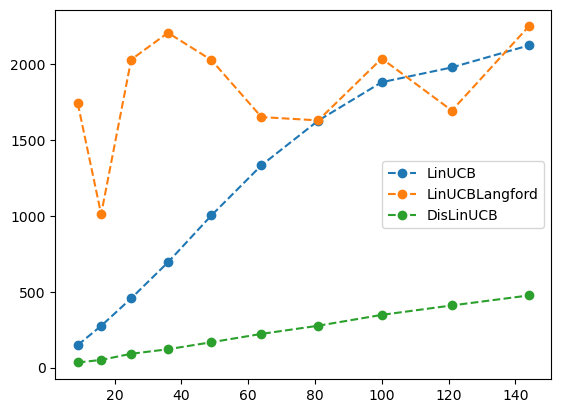

In [176]:
for k in result_dict.keys():
    plt.plot(L_arr, reg_arr[k], '--o', label=k)

plt.legend()
plt.show()

In [56]:
x = np.ones(shape=1)
np.dot(2*x[:-1]/np.linalg.norm(x[:-1]), np.array([])) + 1

1.0